In [69]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, TensorDataset
import re
import string
from sklearn.preprocessing import StandardScaler

In [ ]:
## confusion matrix
## Histogram probability for 1 and 0

In [2]:
# !pip install transformers

In [70]:
import pandas as pd

df = pd.read_csv('resfe_df_delivery_mode_2024-02-23.csv')
data_cleaned = df.copy(deep=True)

data_cleaned.drop(columns='elective_emergency',inplace=True)

In [71]:
# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    return text


In [72]:
# Preprocess the text data and split the dataset
data_cleaned['preprocessed_text'] = data_cleaned['diagnosis'].apply(preprocess_text)
X = data_cleaned.drop(columns=['delivery_mode_NVD', 'diagnosis'])
y = data_cleaned['delivery_mode_NVD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract and preprocess numerical features
numerical_features = X_train.drop(columns=['preprocessed_text', 'patient_id'])  # Adjust as necessary
numerical_features_test = X_test.drop(columns=['preprocessed_text', 'patient_id'])  # Adjust as necessary

In [73]:
int_cols=['age', 'hb', 'ga_weeks','kg_upd','height_upd','bmi','abortion','living_children','parity','gravida','upd_cervix_length','upd_afi','efw_upd' ]
scaler = StandardScaler()

# Fit the scaler on the numerical columns of the training data and transform
numerical_features[int_cols] = scaler.fit_transform(numerical_features[int_cols])

# Transform the numerical columns of the test data using the same scaler
numerical_features_test[int_cols] = scaler.transform(numerical_features_test[int_cols])

In [74]:

# Define a function to preprocess text
def preprocess_text(text):
    # Your preprocessing code here
    return processed_text

bert_model = "dmis-lab/biobert-v1.1"
# # Assuming X contains features and y contains labels
# X = data_cleaned.drop(columns=['delivery_mode_NVD', 'diagnosis'])
# y = data_cleaned['delivery_mode_NVD']
# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Processing {bert_model}...")
tokenizer = AutoTokenizer.from_pretrained(bert_model)
model = AutoModel.from_pretrained(bert_model, output_hidden_states=True)



number_hidden_states=3
train_hidden_states_list = []
# Process in batches
for batch in np.array_split(np.array(X_train['preprocessed_text']), 10):
    inputs = tokenizer(batch.tolist(), return_tensors="pt", padding=True, truncation=True, max_length=30)
    with torch.no_grad():
    
        outputs = model(**inputs)
        # Correctly extract the last four hidden states
        hidden_states = outputs.hidden_states[-(number_hidden_states):]  # This is a tuple of the last four layers
        # Concatenate the last four layers for each token across the batch
        concatenated_layers = torch.cat([hidden_states[i] for i in range(number_hidden_states)], dim=-1)  # Now shape is [batch_size, seq_length, 4*hidden_size]

        
    train_hidden_states_list.append(concatenated_layers)
    ##### updated code end
  
   
## Concatenate along the batch dimension
train_hidden_states = torch.cat(train_hidden_states_list, dim=0)

## Code update start for train
tensor = torch.tensor(numerical_features.values, dtype=torch.float32)
batch_size = tensor.shape[0]

# Reshape tensor to match batch size
tensor = tensor.view(batch_size, -1)

train_hidden_states_upd = torch.cat([train_hidden_states, tensor.unsqueeze(1).repeat(1, 30, 1)], dim=-1)
## Code update end for train



# Optionally convert to numpy if needed
# train_hidden_states = train_hidden_states.numpy()
print(train_hidden_states_upd.shape)
test_hidden_states_list = []
# Process in batches
for batch in np.array_split(np.array(X_test['preprocessed_text']), 20):
    inputs = tokenizer(batch.tolist(), return_tensors="pt", padding=True, truncation=True, max_length=30)
    with torch.no_grad():
        outputs = model(**inputs)
        # Correctly extract the last four hidden states
        hidden_states = outputs.hidden_states[-(number_hidden_states):]  # This is a tuple of the last four layers
        # Concatenate the last four layers for each token across the batch
        concatenated_layers = torch.cat([hidden_states[i] for i in range(number_hidden_states)], dim=-1)  # Now shape is [batch_size, seq_length, 4*hidden_size]
    test_hidden_states_list.append(concatenated_layers)
# Concatenate along the batch dimension
test_hidden_states = torch.cat(test_hidden_states_list, dim=0)

###Code update start###
tensor_test = torch.tensor(numerical_features_test.values, dtype=torch.float32)
batch_size = tensor_test.shape[0]

# Reshape tensor to match batch size
tensor_test = tensor_test.view(batch_size, -1)

test_hidden_states_upd = torch.cat([test_hidden_states, tensor_test.unsqueeze(1).repeat(1, 30, 1)], dim=-1)


# Optionally convert to numpy if needed
# train_hidden_states = train_hidden_states.numpy()
print(test_hidden_states_upd.shape)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Assuming classification task
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
# Create TensorDataset instances
train_dataset = TensorDataset(train_hidden_states_upd, y_train_tensor)
test_dataset = TensorDataset(test_hidden_states_upd, y_test_tensor)
# Create DataLoader instances
batch_size = 32  # Adjust based on your preference and system capability
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

Processing dmis-lab/biobert-v1.1...
torch.Size([255, 30, 2342])
torch.Size([64, 30, 2342])


In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class CustomCNN(nn.Module):
    # 5 different sizes of kernels with 32 times each for 1d data as input
    def __init__(self, num_filters=32, filter_sizes= [1,2,3,4,5], num_classes=2):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        feature_size = number_hidden_states*768+ numerical_features.shape[1] # 4*768+numericals
        for size in filter_sizes:
            # Assuming the input is reshaped to [batch_size, 1, seq_length, 3072] before being passed to the model
            conv_layer = nn.Conv2d(in_channels=1,
                                   out_channels=num_filters,
                                   kernel_size=(size, feature_size),
                                   stride=(1, feature_size))
            self.conv_layers.append(conv_layer)
        self.linear = nn.Linear(num_filters * len(filter_sizes), num_classes)
    def forward(self, x):
        # Reshape x to add a channel dimension ([batch_size, seq_length, 3072] -> [batch_size, 1, seq_length, 3072])
        x = x.unsqueeze(1)  # Add channel dimension
        conv_outputs = []
        for conv_layer in self.conv_layers:
            conv_out = F.relu(conv_layer(x))
            # Since our convolution outputs will have a reduced "height", we pool over the entire height
            conv_out = F.avg_pool2d(conv_out, kernel_size=(conv_out.size(2), 1))
            conv_outputs.append(conv_out.squeeze(2))  # Remove the dimension of size 1 after pooling
        concat_out = torch.cat(conv_outputs, dim=1)
        flat_out = torch.flatten(concat_out, start_dim=1)
        output = self.linear(flat_out)
        return output
    
 

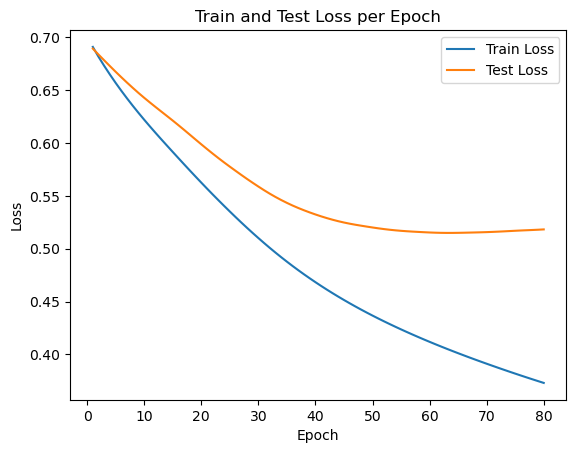

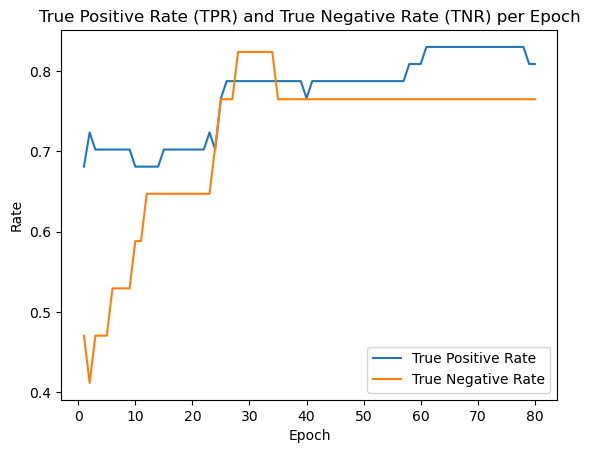

In [90]:
### Code to calculate loss



import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

model = CustomCNN()
# Define lists to store train and test loss values
train_losses = []
test_losses = []

# Define lists to store TPR and TNR values
tpr_values = []
tnr_values = []

# Number of training epochs
num_epochs = 80

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-5)
class_weights = torch.tensor([3, 1], dtype=torch.float32).to(device)  # Assuming binary classification
criterion = nn.CrossEntropyLoss(weight=class_weights)
###################
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model in training mode
    train_loss = 0.0
    for inputs, labels in train_loader:  # Iterate over the training dataset
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the parameters
        train_loss += loss.item() * inputs.size(0)  # Accumulate the training loss
    train_loss = train_loss / len(train_loader.dataset)  # Calculate average training loss
    train_losses.append(train_loss)  # Store train loss
    
    # Evaluate on the test dataset
    model.eval()  # Set the model in evaluation mode
    test_loss = 0.0
    correct_predictions = 0
    true_negatives = 0
    true_positives = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, labels in test_loader:  # Iterate over the test dataset
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            test_loss += loss.item() * inputs.size(0)  # Accumulate the test loss
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
            
            correct_predictions += (predicted == labels).sum().item()  # Count correct predictions
            true_negatives += ((predicted == 0) & (labels == 0)).sum().item()  # Count true negatives
            true_positives += ((predicted == 1) & (labels == 1)).sum().item()  # Count true positives
            # Store probabilities (use softmax outputs if available) and true labels for ROC AUC calculation
            probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Assuming your model outputs raw logits
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(probs.cpu().numpy())
    
    test_loss = test_loss / len(test_loader.dataset)  # Calculate average test loss
    test_losses.append(test_loss)  # Store test loss
    
    # Calculate true positive rate (TPR) and true negative rate (TNR)
    total_actual_positives = sum((labels == 1).sum().item() for _, labels in test_loader)
    total_actual_negatives = sum((labels == 0).sum().item() for _, labels in test_loader)
    true_positive_rate = true_positives / total_actual_positives if total_actual_positives > 0 else 0
    true_negative_rate = true_negatives / total_actual_negatives if total_actual_negatives > 0 else 0
    
    # Append TPR and TNR values to the lists
    tpr_values.append(true_positive_rate)
    tnr_values.append(true_negative_rate)

# Plot train and test loss values per epoch
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss per Epoch')
plt.legend()
plt.show()

plt.plot(epochs, tpr_values, label='True Positive Rate')
plt.plot(epochs, tnr_values, label='True Negative Rate')
plt.xlabel('Epoch')
plt.ylabel('Rate')
plt.title('True Positive Rate (TPR) and True Negative Rate (TNR) per Epoch')
plt.legend()
plt.show()


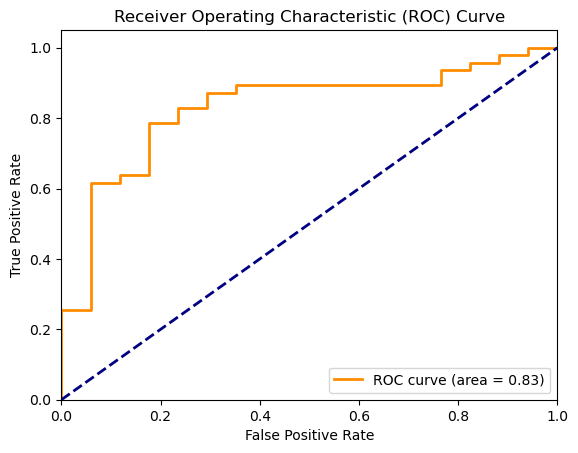

Confusion Matrix:
[[13  4]
 [ 9 38]]


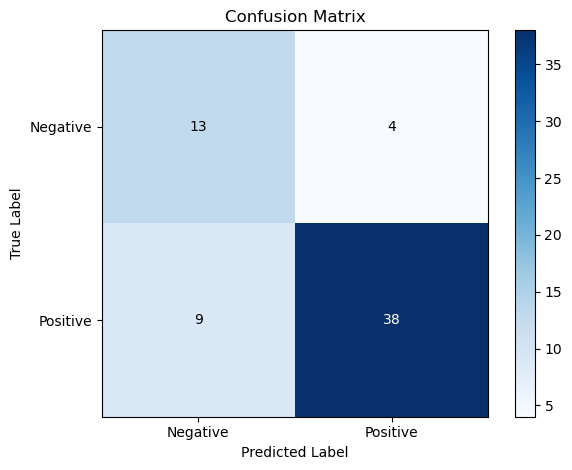

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Assuming 'true_labels' contains true labels (0 or 1) and 'predicted_probs' contains predicted probabilities for the positive class
# 'predicted_probs' should be a 1D array or list containing probabilities for the positive class

# Compute ROC curve and ROC area for positive class
fpr, tpr, _ = roc_curve(labels, all_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute confusion matrix
threshold = 0.5  # Threshold for class prediction
predicted_labels = np.where(all_predictions_df[0] >= threshold, 1, 0)
conf_matrix = confusion_matrix(labels, predicted_labels)

# Plot confusion matrix
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])

# Display values within the confusion matrix
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()

# Print confusion matrix values
print("Confusion Matrix:")
print(conf_matrix)

plt.show()


In [ ]:
# ## This is for average pooling iwth small filters in CNN model (1,2,3,4,5)


# import torch.optim as optim
# import torch.nn as nn
# from sklearn.metrics import roc_auc_score

# # Define the custom CNN model
# model = CustomCNN()

# # Define the optimizer
# optimizer = optim.Adam(model.parameters(), lr=2e-5)

# # Define the loss function
# # We will use a weighted version of the CrossEntropyLoss to handle class imbalance
# # Define the class weights to penalize false negatives more than false positives
# class_weights = torch.tensor([3, 1], dtype=torch.float32).to(device)  # Assuming binary classification
# criterion = nn.CrossEntropyLoss(weight=class_weights)

# # Number of training epochs
# # num_epochs = 30

# import torch.optim as optim
# import torch.nn as nn
# from sklearn.metrics import roc_auc_score
# import matplotlib.pyplot as plt

# # Define lists to store TPR and TNR values
# tpr_values = []
# tnr_values = []

# # Number of training epochs
# num_epochs = 100

# # Training loop
# for epoch in range(num_epochs):
#     model.train()  # Set the model in training mode
#     train_loss = 0.0
#     for inputs, labels in train_loader:  # Iterate over the training dataset
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()  # Zero the gradients
#         outputs = model(inputs)  # Forward pass
#         loss = criterion(outputs, labels)  # Calculate the loss
#         loss.backward()  # Backward pass
#         optimizer.step()  # Update the parameters
#         train_loss += loss.item() * inputs.size(0)  # Accumulate the training loss
#     train_loss = train_loss / len(train_loader.dataset)  # Calculate average training loss
    
#     # Evaluate on the test dataset
#     model.eval()  # Set the model in evaluation mode
#     test_loss = 0.0
#     correct_predictions = 0
#     true_negatives = 0
#     true_positives=0
#     all_labels = []
#     all_predictions = []
#     with torch.no_grad():  # Disable gradient calculation during validation
#         for inputs, labels in test_loader:  # Iterate over the test dataset
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)  # Forward pass
#             loss = criterion(outputs, labels)  # Calculate the loss
#             test_loss += loss.item() * inputs.size(0)  # Accumulate the test loss
#             _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
            
#             correct_predictions += (predicted == labels).sum().item()  # Count correct predictions
#             true_negatives += ((predicted == 0) & (labels == 0)).sum().item()  # Count true negatives
#             true_positives += ((predicted == 1) & (labels == 1)).sum().item()  # Count true negatives
#             # Store probabilities (use softmax outputs if available) and true labels for ROC AUC calculation
#             probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Assuming your model outputs raw logits
#             all_labels.extend(labels.cpu().numpy())
#             all_predictions.extend(probs.cpu().numpy())
            
#     test_loss = test_loss / len(test_loader.dataset)  # Calculate average test loss
#     accuracy = correct_predictions / len(test_loader.dataset)  # Calculate test accuracy
#     auc_roc_score = roc_auc_score(all_labels, all_predictions)  # Calculate AUC ROC score
    
#     # Calculate true positive rate (TPR) and true negative rate (TNR)
#     total_actual_positives = sum((labels == 1).sum().item() for _, labels in test_loader)
#     total_actual_negatives = sum((labels == 0).sum().item() for _, labels in test_loader)
#     true_positive_rate = true_positives / total_actual_positives if total_actual_positives > 0 else 0
#     true_negative_rate = true_negatives / total_actual_negatives if total_actual_negatives > 0 else 0
    
#     # Append TPR and TNR values to the lists
#     tpr_values.append(true_positive_rate)
#     tnr_values.append(true_negative_rate)
    
#     # Print the epoch, training loss, test loss, test accuracy, AUC ROC score, TPR, and TNR
#     # print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}, AUC ROC: {auc_roc_score:.4f}, True Positive Rate: {true_positive_rate:.4f}, True Negative Rate: {true_negative_rate:.4f}')

# # Plot TPR and TNR values per epoch
# epochs = range(1, num_epochs + 1)
# plt.plot(epochs, tpr_values, label='True Positive Rate')
# plt.plot(epochs, tnr_values, label='True Negative Rate')
# plt.xlabel('Epoch')
# plt.ylabel('Rate')
# plt.title('True Positive Rate (TPR) and True Negative Rate (TNR) per Epoch')
# plt.legend()
# plt.show()
